In [31]:
# Carter McGee A02248916
import cmath, math
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from scipy import stats
import gc

In [12]:
# generate an omegalist using trig
def get_omegalist(howMany):
  angleList = [i*2*math.pi/howMany for i in range(0, howMany)]
  omegaList = [complex(math.cos(angle), math.sin(angle)) for angle in angleList]
  return omegaList
             

FFT Algorithm

In [13]:
def FFT(P, X, n):
  # P is the input coeficients of the polynomial (must be complex numbers)
  # X is the omega array of size n
  # n is the length of X and P
  # returns a list of values of P at x_i of length 1*n
  if n == 1:
    return [P[0]]
  m = n//2
  # prob decomposition
  # odd and even
  P_odd = [P[i] for i in range(1,n,2)]
  P_even = [P[i] for i in range(0,n,2)]
  # omega squared array size m
  newX = [X[i]*X[i] for i in range(0, m)]
  # Solve the smaller problems
  Sol_odd = FFT(P_odd, newX, m)
  Sol_even = FFT(P_even, newX, m)
  # solution construction
  Sol_P = [0]*n
  for i in range(m):
    # P(x) = P_e(x^2) + x*P_o(x^2)
    # P(-x) = P_e(x^2) - x*P_o(x^2)
    Sol_P[i] = Sol_even[i] + X[i]*Sol_odd[i]
    Sol_P[i+m] = Sol_even[i] - X[i]*Sol_odd[i]
  return Sol_P
  

FFT Polynomial Multiplication Algorithm

In [14]:
def FFT_poly_mult(P, Q, n):
  P += [0]*n
  Q += [0]*n
  omega = get_omegalist(2*n)
  P_fft = FFT(P, omega, 2*n)
  Q_fft = FFT(Q, omega, 2*n)

  PQ = [0]*2*n
  for i in range(2*n):
    PQ[i] = P_fft[i]*Q_fft[i]

  conjugate = []
  for term in omega:
    conjugate.append(term.conjugate())
  
  PQ = FFT(PQ, conjugate, 2*n)
  return [int(round(PQ[i].real)/(2*n)) for i in range(2*n)]


In [15]:
def polyMult3(P, Q, n):
  # input is P and Q of length n, solution is the product of the polynomials of length 2*n
  # simple problem --> simple solution
  if n == 1:
    return [P[0] * Q[0], 0] # need to add the high order term because must return solution of length 2*n
  m = n//2
  # generate 3 problems of 1/2 size and solve them
  # PQ = sol_2 + (sol_1-sol_2-sol_3)x + (sol_3)x^2
  Padd = [P[i] + P[i+m] for i in range(0,m)]
  Qadd = [Q[i] + Q[i+m] for i in range(0,m)]
  sol_1 = polyMult3(Padd, Qadd, m)
  sol_2 = polyMult3(P[0:m], Q[0:m], m)
  sol_3 = polyMult3(P[m:], Q[m:], m)

  # reconstruct the solution. Use the powers of x in the math as indexes!
  PQ = [0]*2*n # solution is of length 2n
  for i in range(0, n):
    PQ[i] += sol_2[i]
    PQ[i + m] += (sol_1[i] - sol_2[i] - sol_3[i])
    PQ[i + n] += sol_3[i]

  return PQ

In [16]:
def polyMultSchool(P, Q, n):
  # P Q are polynomials of length n
  # create an array of the solution
  PQ = [0]*2*n
  # enumerate through each coeficient in P
  for i in range(0, n):
    # enumerate through each coeficient in Q
    for j in range(0, n):
      # multiply the coeficients AND ACCUMULATE THEM IN THE CORRECT PLACE IN THE SOLUTION
      # recall that (p_i * x^i) * (q_j * x^j) = p_i * q_j * x^(i+j)
      PQ[i+j] = PQ[i+j] + P[i] * Q[j]
      # since many combinations of i and j lead to the same sum, we have to accumulate the values
  return PQ

Test that the FFT algorithm, 3 Subproblems Algorithm, and High School Algorithm return the same answer

In [17]:
def test_results():
  print('Testing that the FFT algorithm, 3 Subproblems Algorithm, and High School Algorithm return the same answer...')
  print('  Integers:')
  for n in range(1, 13):
    for i in range(3):
      P = [random.randint(0,100) for j in range(2**n)]
      Q = [random.randint(0,100) for j in range(2**n)]
      hs_result = polyMultSchool(P, Q, 2**n)
      pm3_result = polyMult3(P, Q, 2**n)
      fft_result = FFT_poly_mult(P, Q, 2**n)
      test_passed = (fft_result == pm3_result) and (fft_result == hs_result)
      print('\tRandom problem of size ', 2**n, '\t: ', test_passed)

test_results()

Testing that the FFT algorithm, 3 Subproblems Algorithm, and High School Algorithm return the same answer...
  Integers:
	Random problem of size  2 	:  True
	Random problem of size  2 	:  True
	Random problem of size  2 	:  True
	Random problem of size  4 	:  True
	Random problem of size  4 	:  True
	Random problem of size  4 	:  True
	Random problem of size  8 	:  True
	Random problem of size  8 	:  True
	Random problem of size  8 	:  True
	Random problem of size  16 	:  True
	Random problem of size  16 	:  True
	Random problem of size  16 	:  True
	Random problem of size  32 	:  True
	Random problem of size  32 	:  True
	Random problem of size  32 	:  True
	Random problem of size  64 	:  True
	Random problem of size  64 	:  True
	Random problem of size  64 	:  True
	Random problem of size  128 	:  True
	Random problem of size  128 	:  True
	Random problem of size  128 	:  True
	Random problem of size  256 	:  True
	Random problem of size  256 	:  True
	Random problem of size  256 	: 

Time Evaluation Experiment

In [18]:
##Calculates the time taken by each function call and generates graph
def timeCompareFunctions(problemList, functionList, init = None, fit = 'exponential'):
  #problemList is a list of tuples [(size, arguments),...] ordered smallest to biggest
  #runs and times the functions contained in functionList with each arguments 
  #generates a graph of run time as a function of problem size
  # fit may be 'exponential' then the time as a function of problem size is assumed
  #     to of the form time = c * a^n and the function solves for c and a
  #     where a is the base of the exponential function and c is a multiplicative factor
  # fit my be 'polynomial' then the time as a function of problem size is assumed
  #     to of the form time = c * n ^ b and the function solves for c and b 
  #     where b is the power of n (the degree of the polynomial) and c is a multiplicative factor
  # setup the graph
    plt.xlabel("Problem size")
    plt.yscale('log')
    if fit == 'polynomial':
      plt.xscale('log')
    plt.ylabel("time in milliseconds")
    plt.rcParams["figure.figsize"] = [16,9]
 # get the problem sizes
    values = [size for (size, args) in problemList]
    # if not functionList is list:
    #   functionList = [functionList]
    # loop through each function
    for function in functionList:
      functionName = str(function).split(" ")[1]
      timeLine = []
      for (size, args) in problemList:
        start_time = time.time()
        function(*args) #use the * to unpack the tuple into arguments to the function
        elapsed = (time.time() - start_time)*1000.0
        timeLine.append(elapsed)
      ##Generating the plot between time taken by each function call with n as variable and n
      plt.plot(values, timeLine, label = functionName)
      # fit these timing studies to a curve
      if fit == 'exponential': #fit a straight line to n and log time
        slope, intercept, _, _, _ = stats.linregress([values], [np.log(t) for t in timeLine])
        print("Function %s time = %.6f %.3f ^ n" % (functionName, np.exp(intercept), np.exp(slope)))
      elif fit == 'polynomial': # fit a straight line to log n and log time
        slope, intercept, _, _, _ = stats.linregress([np.log(v) for v in values], [np.log(t) for t in timeLine])
        print("Function %s time = %.6f n ^ %.3f" % (functionName, np.exp(intercept), slope))
    plt.legend(loc='upper left')
    plt.show()

Function polyMultSchool time = 0.000278 n ^ 1.939
Function FFT_poly_mult time = 0.019460 n ^ 1.064
Function polyMult3 time = 0.002820 n ^ 1.550


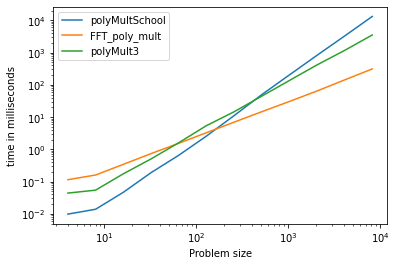

In [19]:
problemSizes = [2**i for i in range(2, 14)]
problemList = [(i, ([random.randint(0,100) for j in range(0,i)], 
                    [random.randint(0,100) for j in range(0,i)], i)) for i in problemSizes]
timeCompareFunctions(problemList, [polyMultSchool, FFT_poly_mult, polyMult3], init = None, fit = 'polynomial')

In [ ]:
for i in range(1,100):
  FFT_poly_mult([random.randint(0,100) for j in range(0,2**i)], [random.randint(0,100) for j in range(0,2**i)], 2**i)
  print('Problem Size '+ str(2**i) + ':\t Success')
  gc.collect()


Problem Size 2:	 Success
Problem Size 4:	 Success
Problem Size 8:	 Success
Problem Size 16:	 Success
Problem Size 32:	 Success
Problem Size 64:	 Success
Problem Size 128:	 Success
Problem Size 256:	 Success
Problem Size 512:	 Success
Problem Size 1024:	 Success
Problem Size 2048:	 Success
Problem Size 4096:	 Success
Problem Size 8192:	 Success
Problem Size 16384:	 Success
Problem Size 32768:	 Success
Problem Size 65536:	 Success
Problem Size 131072:	 Success
Problem Size 262144:	 Success
Problem Size 524288:	 Success
Problem Size 1048576:	 Success
Problem Size 2097152:	 Success
Problem Size 4194304:	 Success
Problem Size 8388608:	 Success
Problem Size 16777216:	 Success


I ran the FFT algorithm for problem sizes 2^1 - 2^100 and the remote computer ran out of RAM at problem size 2^24 before the algorithm crashed.